<a href="https://colab.research.google.com/github/tsangrebecca/PersonalProjects/blob/main/Predicting_Steph_Currys_Shots_in_basketball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders


# Predict Steph Curry's Shots 🏀

This dataset is all of Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs) collected with the [nba_api](https://github.com/swar/nba_api) Python library.

The goal is to predict whether Curry will make a shot based on his past perfomance.

# Steps

- **Step 1:** Importing data.
- **Step 2:** Feature engineering.
- **Step 3:** Splitting data into a feature matrix and target vector.
- **Step 4:** Splitting data into training, validation, and test sets.
- **Step 5:** Establishing baseline accuracy.
- **Step 6:** Building a model with a transformer and a tree-based predictor.
- **Step 7:** Calculating training and validation accuracy.
- **Step 8 (`stretch goal`):** Tuning model hyperparameters.
- **Step 9:** Calculating precision and recall from a confusion matrix.
- **Step 10 (`stretch goal`):** Plotting a confusion matrix.


In [ ]:
from category_encoders import OrdinalEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

# I. Wrangle Data

In [ ]:
import pandas as pd

url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url,
                 parse_dates=['game_date'],
                 index_col='game_date')

In [ ]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [ ]:
# url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
# df = pd.read_csv(url,
#                  parse_dates=['game_date'],
#                  index_col='game_date')

# ADD FEATURE secs_left_in_period column
df['total_seconds_remaining'] = df['minutes_remaining']*60 + df['seconds_remaining']
# # drop duplicate and constant columns
# columns_to_drop = ['minutes_remaining', 'seconds_remaining'] # not dropping player_name to pass the test
# df = df.drop(columns=columns_to_drop)
# change name
# df = df.rename(columns={'total_seconds_remaining': 'secs_left_in_period'})

# ADD FEATURE if game is overtime
df['overtime'] = (df['period'] == 5) | (df['period'] == 6)
df['overtime'] = df['overtime'].astype(int)

# ADD FEATURE 'home_adv' with True for 'gsw' and False otherwise
df['home_adv'] = df['htm'] == 'GSW'
# Convert True and False to 1 and 0 in the 'is_gsw' column
df['home_adv'] = df['home_adv'].astype(int)

# convert objects to string
# df['action_type'] = df['action_type'].astype(str) <--- necessary?

# # parse date
# df['game_date'] = pd.to_datetime(df['game_date'])

# we don't have missing values!

In [ ]:
df.shape

(13958, 22)

# II. Split Data

In [ ]:
target = 'shot_made_flag'
y = df[target]
X = df.drop(columns=target)

- training set (`X_train`, `y_train`) contains games from the 2009-10 season through the end of the 2016-17 season.
- validation set (`X_val`, `y_val`) contains games from the 2017-18 season.
- test set (`X_test`, `y_test`) contains games from the 2018-2019 season.
- The NBA season begins in October and ends in June.

In [ ]:
# Set the date cutoffs for training, validation, and testing
train_cutoff = '2017-07-01'
val_cutoff = '2018-07-01'

# Create boolean masks based on date cutoffs
train_mask = X.index < train_cutoff
val_mask = (X.index >= train_cutoff) & (X.index < val_cutoff)
test_mask = X.index >= val_cutoff

# Split the data using the masks
X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_val, y_val = X.loc[val_mask], y.loc[val_mask]
X_test, y_test = X.loc[test_mask], y.loc[test_mask]

In [ ]:
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

In [ ]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


# IV. Build Model

In [ ]:
model = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_estimators=25, n_jobs=-1, random_state=42)
)

model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['player_name', 'action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type'],
                                mapping=[{'col': 'player_name',
                                          'data_type': dtype('O'),
                                          'mapping': Stephen Curry    1
NaN             -2
dtype: int64},
                                         {'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                              1
Step Back Jump shot                    2
P...
MEM     3
LAC     4
MIN     5
POR     6
LAL     7
IND     8
ORL     9
SAS    10
WAS    11
PHX    12
BOS    13
SAC    14
CLE    15
MIA    16
MIL    17
CHI    18
DEN    19
NJN    20
NOH    21
CHA    22
OKC    23
DAL    24
UTA    25
ATL    26
PHI    27
DET    28
TOR    29
NYK    30
BKN    31
NOP    32
NaN    -2
dtype: int64},
                                         {'col': 'season_type',
                                          'data_type': dtype('O'),
                                          'mapping': Regular Season    1
Playoffs          2
NaN              -2
dtype: int64}])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=25, n_jobs=-1,
                                        random_state=42))])

# V. Check Metrics

In [ ]:
train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9986463315585236
Validation Accuracy Score: 0.571917808219178


# VI. Tune Model

Perform tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`.
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.

- Because I already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

If model's performance on the validation set has a score above `0.6`, then it's not terrible. Also need to calculate its accuracy with test set.

In [ ]:
param_grid = {
    'randomforestclassifier__max_depth': range(5,40,5),
    'randomforestclassifier__n_estimators': range(25,125,25),
    'randomforestclassifier__max_samples': [0.1,0.3,0.5,0.7,0.9,1.0],
    # 'randomforestclassifier__learning_rate': range(5, 40, 5)
}

model_random_search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_jobs=-1,
    verbose=1,
    n_iter=3,
)

model_random_search.fit(X_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['player_name',
                                                                   'action_type',
                                                                   'shot_type',
                                                                   'shot_zone_basic',
                                                                   'shot_zone_area',
                                                                   'shot_zone_range',
                                                                   'htm', 'vtm',
                                                                   'season_type'],
                                                             mapping=[{'col': 'player_name',
                                                                       'data_type': dtype('O'),
                                                                       'mapping': Stephen Curry    1
NaN             -2
dtype: int64},
                                                                      {'col': 'action_type',
                                                                       'data_type': dtype('O'),
                                                                       'mapping...
                                                                       'mapping': Regular Season    1
Playoffs          2
NaN              -2
dtype: int64}])),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_estimators=25,
                                                                     n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=3, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(5, 40, 5),
                                        'randomforestclassifier__max_samples': [0.1,
                                                                                0.3,
                                                                                0.5,
                                                                                0.7,
                                                                                0.9,
                                                                                1.0],
                                        'randomforestclassifier__n_estimators': range(25, 125, 25)},
                   verbose=1)

In [ ]:
test_acc = model_random_search.best_score_
print('Testing Accuracy Score:', test_acc)

Testing Accuracy Score: 0.6056147210646362


# VII. Communication

Confusion matrix for my model using my **test data**.

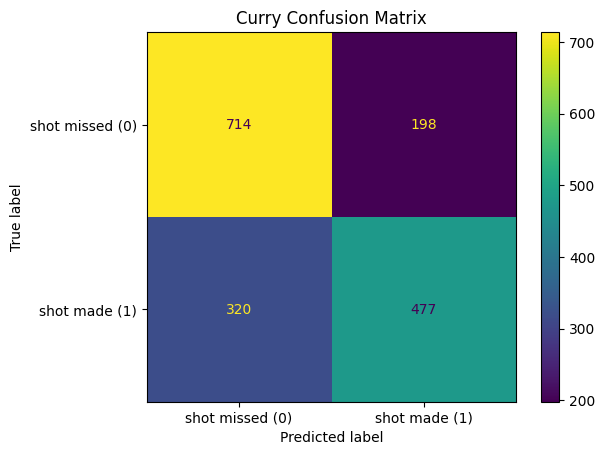

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    model_random_search,
    X_test,
    y_test,
    display_labels=['shot missed (0)', 'shot made (1)']
)

plt.title('Curry Confusion Matrix');

In [ ]:
my_precision = 477 / (477+198)
my_recall = 477 / (477+320)
print('My model precision', instructor_precision)
print('My model recall', instructor_recall)

My model precision 0.5816216216216217
My model recall 0.6750313676286073
